# **Tarea 8 : Arboles**

* Shu-yi Wong Baxter
* Sebastian Perez Berrios
* Mathias Cáceres Bustamante

In [38]:
import csv
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.tree import export_text
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
path = '/content/drive/My Drive/Mineria de datos(Modelo)'

Mounted at /content/drive/


In [3]:
datos=pd.read_csv("/content/drive/My Drive/Mineria de datos(Modelo)/avance 5.5.csv", sep=';')

In [4]:
#Elimina los nulos de date que son pocos y eso hace que se eliminen los nulos pequeños que
# estan en la misma fila y quedan las columnas que se usaran sin nulos
datos.drop(datos[datos.date.isnull()].index, inplace = True) #Ojo aqui, el inplace true los elimina del dataset original, no hace una copia

In [5]:
#Crea la columna heridos que es el target, junta los valores de n_killed y n_injured
datos.loc[(datos.n_killed==0.0)&(datos.n_injured==0.0) ,'heridos']=0;
datos.loc[(datos.n_killed>=1.0)&(datos.n_injured==0.0) ,'heridos']=1;
datos.loc[(datos.n_killed==0.0)&(datos.n_injured>=1.0) ,'heridos']=1;
datos.loc[(datos.n_killed>=1.0)&(datos.n_injured>=1.0) ,'heridos']=1;

In [6]:
datos.loc[(datos.state==7.0)|(datos.state==9.0)|(datos.state==12.0)|(datos.state==15.0)|(datos.state==18.0)|(datos.state==23.0)|(datos.state==24.0)|(datos.state==25.0)|(datos.state==33.0)|(datos.state==35.0)|(datos.state==41.0)|(datos.state==45.0)|(datos.state==47.0),'state2']=0;
datos.loc[(datos.state==3.0)|(datos.state==8.0)|(datos.state==16.0)|(datos.state==20.0)|(datos.state==26.0)|(datos.state==27.0)|(datos.state==31.0)|(datos.state==32.0)|(datos.state==39.0)|(datos.state==44.0)|(datos.state==50.0),'state2']=1;
datos.loc[(datos.state==0.0)|(datos.state==1.0)|(datos.state==4.0)|(datos.state==6.0)|(datos.state==10.0)|(datos.state==11.0)|(datos.state==13.0)|(datos.state==14.0)|(datos.state==17.0)|(datos.state==19.0)|(datos.state==21.0)|(datos.state==22.0)|(datos.state==28.0)|(datos.state==29.0)|(datos.state==34.0)|(datos.state==37.0)|(datos.state==38.0)|(datos.state==40.0)|(datos.state==42.0)|(datos.state==46.0)|(datos.state==48.0)|(datos.state==49.0),'state2']=2;
datos.loc[(datos.state==2.0)|(datos.state==5.0)|(datos.state==30.0)|(datos.state==36.0)|(datos.state==43.0) ,'state2']=3;

In [7]:
datos2 = datos.drop_duplicates()
datos2 = datos.drop(['incident_id','date','address','incident_characteristics','location_description','latitude','longitude','notes','city_or_county','congressional_district','n_killed','n_injured','state'], axis=1) #Eliminar columnas correlacionales a global_sales
datos2.loc[(datos2.avg_age>=0.0)&(datos2.avg_age<18.0) ,'avg_age']=0;
datos2.loc[(datos2.avg_age>=18.0)&(datos2.avg_age<25.0) ,'avg_age']=1;
datos2.loc[(datos2.avg_age>=25.0)&(datos2.avg_age<45.0) ,'avg_age']=2;
datos2.loc[(datos2.avg_age>=45.0)&(datos2.avg_age<70.0) ,'avg_age']=3;
datos2.loc[(datos2.avg_age>=70.0) ,'avg_age']=4;
datos2.drop(datos2[datos2.avg_age.isnull()].index, inplace = True)

In [8]:
datos3=datos2.copy()
datos3 = datos3.drop(['heridos'], axis=1) #Eliminar columnas correlacionales a global_sales
variables_independientes = datos3

In [9]:
datos4=datos2.copy()
datos4 = datos4.drop(['month','day','state2','gun_stolen','gun_type','n_guns_involved','participant_age_group','participant_gender','avg_age'], axis=1) #Eliminar columnas correlacionales a global_sales
variables_objetivo = datos4

**Arbol de decision Gini**

In [10]:
# Separamos en dos variables (X e Y)
X = datos3
Y = datos4['heridos']

# Separando los datos en sets de entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

# Importando el arbol de decisión
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

# Creando el modelo con criterio 'gini'
arbolGini = DecisionTreeClassifier(criterion='gini') 

# Ajustando el modelo
arbolGini.fit(X_train, y_train)

print('Precisión modelo inicial train/test  {0:.6f}/{1:.6f}'
      .format(arbolGini.score(X_train, y_train), arbolGini.score(X_test, y_test)))

Precisión modelo inicial train/test  0.802065/0.729558


In [11]:
from sklearn.metrics import confusion_matrix

y_predicted_arbolGini = arbolGini.predict(X_test)
matrizC = confusion_matrix(y_test, y_predicted_arbolGini)
matrizC

array([[11012,  8199],
       [ 4647, 23642]])

Text(69.0, 0.5, 'Truth')

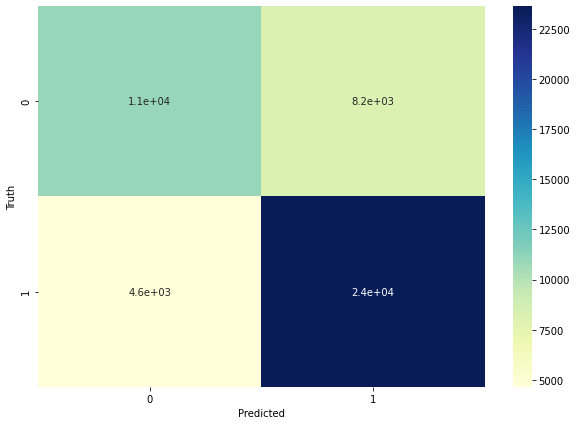

In [12]:
import seaborn as sns

%matplotlib inline
plt.figure(figsize=(10,7))
sns.heatmap(matrizC, annot=True, cmap="YlGnBu")
plt.xlabel('Predicted')
plt.ylabel('Truth')

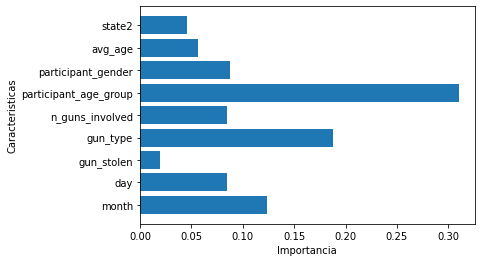

In [13]:
caract = X.shape[1]
plt.barh(range(caract), arbolGini.feature_importances_)
plt.yticks(np.arange(caract), X.columns.values)
plt.xlabel('Importancia')
plt.ylabel('Caracteristicas')
plt.show()

**Arbol decision Cross Entropy**

In [14]:
# Creando el modelo con criterio 'Entropy'
arbolEntropy = DecisionTreeClassifier(criterion='entropy') 
# Ajustando el modelo
arbolEntropy.fit(X_train, y_train) 
print('Precisión modelo inicial train/test  {0:.6f}/{1:.6f}'
      .format(arbolEntropy.score(X_train, y_train), arbolEntropy.score(X_test, y_test)))

Precisión modelo inicial train/test  0.802065/0.730295


In [15]:
y_predicted_arbolEntropy = arbolEntropy.predict(X_test)
matrizC = confusion_matrix(y_test, y_predicted_arbolEntropy)
matrizC

array([[11016,  8195],
       [ 4616, 23673]])

Text(69.0, 0.5, 'Truth')

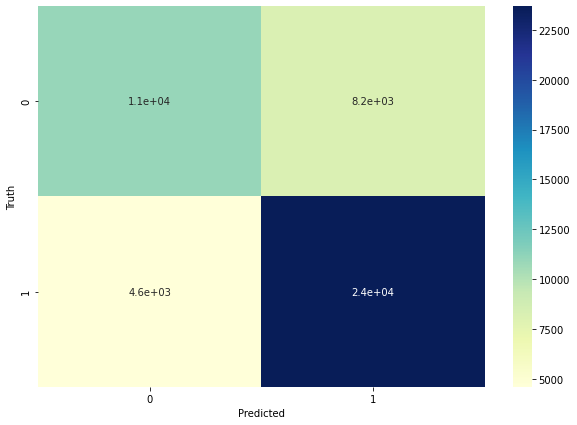

In [16]:
%matplotlib inline
plt.figure(figsize=(10,7))
sns.heatmap(matrizC, annot=True, cmap="YlGnBu")
plt.xlabel('Predicted')
plt.ylabel('Truth')

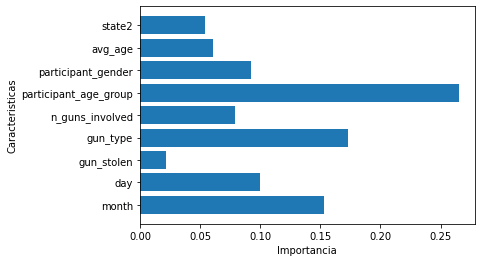

In [17]:
caract = X.shape[1]
plt.barh(range(caract), arbolEntropy.feature_importances_)
plt.yticks(np.arange(caract), X.columns.values)
plt.xlabel('Importancia')
plt.ylabel('Caracteristicas')
plt.show()

**Random Forest**

In [18]:
# Importando el random forest
from sklearn.ensemble import RandomForestClassifier

randomForest = RandomForestClassifier() # Creando el modelo
randomForest.fit(X_train, y_train) # Ajustando el modelo

print('Precisión modelo inicial train/test  {0:.6f}/{1:.6f}'
      .format(randomForest.score(X_train, y_train), randomForest.score(X_test, y_test)))

Precisión modelo inicial train/test  0.802039/0.743642


In [19]:
y_predicted_randomForest = randomForest.predict(X_test)
matrizC = confusion_matrix(y_test, y_predicted_randomForest)
matrizC

array([[10922,  8289],
       [ 3888, 24401]])

Text(69.0, 0.5, 'Truth')

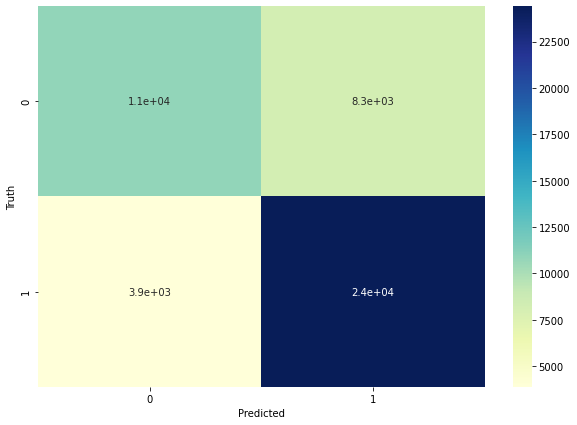

In [20]:
%matplotlib inline
plt.figure(figsize=(10,7))
sns.heatmap(matrizC, annot=True, cmap="YlGnBu")
plt.xlabel('Predicted')
plt.ylabel('Truth')

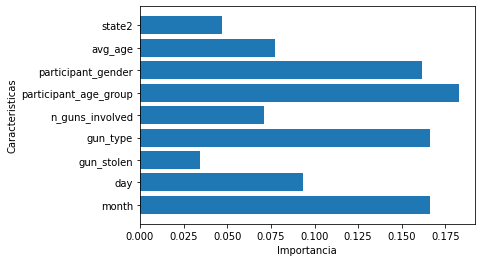

In [21]:
caract = X.shape[1]
plt.barh(range(caract), randomForest.feature_importances_)
plt.yticks(np.arange(caract), X.columns.values)
plt.xlabel('Importancia')
plt.ylabel('Caracteristicas')
plt.show()

**AdaBoost**

In [22]:
# Importando adaBoost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

# Utilizando AdaBoost
adaBoost = AdaBoostClassifier(n_estimators=500, 
                              learning_rate=1.5)
# Ajustando los datos
adaBoost = adaBoost.fit(X_train, y_train)

print('Precisión modelo inicial train/test  {0:.6f}/{1:.6f}'
      .format(adaBoost.score(X_train, y_train), adaBoost.score(X_test, y_test)))

Precisión modelo inicial train/test  0.745249/0.748274


In [23]:
y_predicted_adaBoost = adaBoost.predict(X_test)
matrizC = confusion_matrix(y_test, y_predicted_adaBoost)
matrizC

array([[11281,  7930],
       [ 4027, 24262]])

Text(69.0, 0.5, 'Truth')

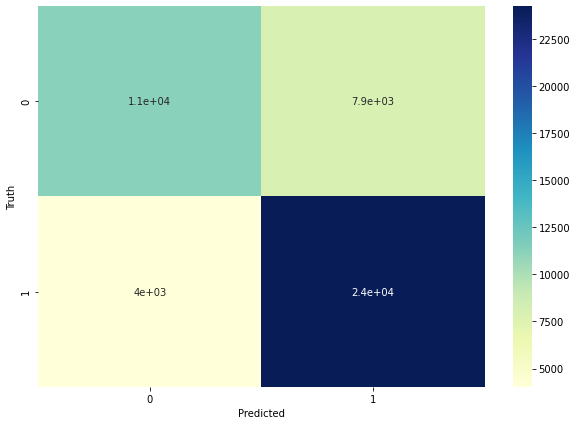

In [24]:
%matplotlib inline
plt.figure(figsize=(10,7))
sns.heatmap(matrizC, annot=True, cmap="YlGnBu")
plt.xlabel('Predicted')
plt.ylabel('Truth')

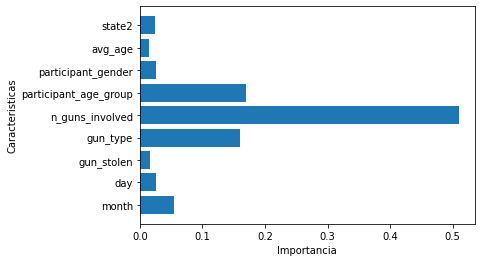

In [25]:
caract = X.shape[1]
plt.barh(range(caract), adaBoost.feature_importances_)
plt.yticks(np.arange(caract), X.columns.values)
plt.xlabel('Importancia')
plt.ylabel('Caracteristicas')
plt.show()

**Gaussian Naive Bayes**

In [26]:
# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html?highlight=gaussiannb#sklearn.naive_bayes.GaussianNB

from sklearn.naive_bayes import GaussianNB

gNaiveBayes = GaussianNB()
gNaiveBayes.fit(X_train, y_train)

print('Precisión modelo inicial train/test  {0:.6f}/{1:.6f}'
      .format(gNaiveBayes.score(X_train, y_train), gNaiveBayes.score(X_test, y_test)))

Precisión modelo inicial train/test  0.723075/0.727116


In [27]:
#Matriz de Confusión
y_predicted_gNaiveBayes = gNaiveBayes.predict(X_test)
matrizC = confusion_matrix(y_test, y_predicted_gNaiveBayes)
matrizC

array([[ 7827, 11384],
       [ 1578, 26711]])

Text(69.0, 0.5, 'Truth')

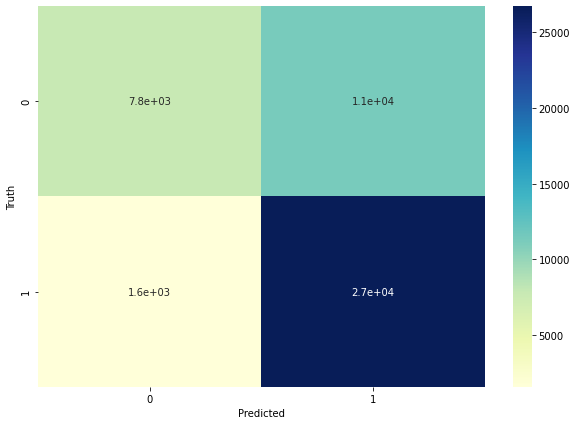

In [28]:
%matplotlib inline
plt.figure(figsize=(10,7))
sns.heatmap(matrizC, annot=True, cmap="YlGnBu")
plt.xlabel('Predicted')
plt.ylabel('Truth')

**EVALUACIÓN**

In [29]:
from sklearn.model_selection import cross_val_score

score_arbolGini = cross_val_score(arbolGini, X, Y, cv=100)
scoreFinal_arbolGini = score_arbolGini.mean()*100
print(scoreFinal_arbolGini)

70.53442894515143


In [30]:
score_arbolEntropy = cross_val_score(arbolEntropy, X, Y, cv=100)
scoreFinal_arbolEntropy = score_arbolEntropy.mean()*100
print(scoreFinal_arbolEntropy)

70.57948476921031


In [31]:
score_randomForest = cross_val_score(randomForest, X, Y, cv=100)
scoreFinal_randomForest = score_randomForest.mean()*100
print(scoreFinal_randomForest)

71.81528719017425


In [32]:
score_adaBoost = cross_val_score(adaBoost, X, Y, cv=100)
scoreFinal_adaBoost = score_adaBoost.mean()*100
print(scoreFinal_adaBoost)

73.92771782024565


In [33]:
score_gNaiveBayes = cross_val_score(gNaiveBayes, X, Y, cv=100)
scoreFinal_gNaiveBayes = score_gNaiveBayes.mean()*100
print(scoreFinal_gNaiveBayes)

72.36936868709263


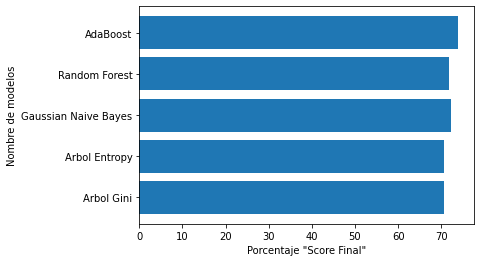

In [34]:
nombres = ['Arbol Gini','Arbol Entropy','Gaussian Naive Bayes','Random Forest','AdaBoost']
datos = [scoreFinal_arbolGini,scoreFinal_arbolEntropy,scoreFinal_gNaiveBayes,scoreFinal_randomForest,scoreFinal_adaBoost]
xx = range(len(datos))

plt.barh(xx, datos)
plt.yticks(xx, nombres)
plt.xlabel('Porcentaje "Score Final"')
plt.ylabel('Nombre de modelos')
plt.show()

**Arboles con profundidad 3,5 (Arbol de decisión, AdaBoost)**

**Arbol profundidad 3**

In [29]:
#se define el modelo del arbol de profundidad 3
modelo = DecisionTreeRegressor( 
            max_depth         = 3,
            random_state = 123
          )

modelo.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=123, splitter='best')

Profundidad del árbol: 3
Número de nodos terminales: 8


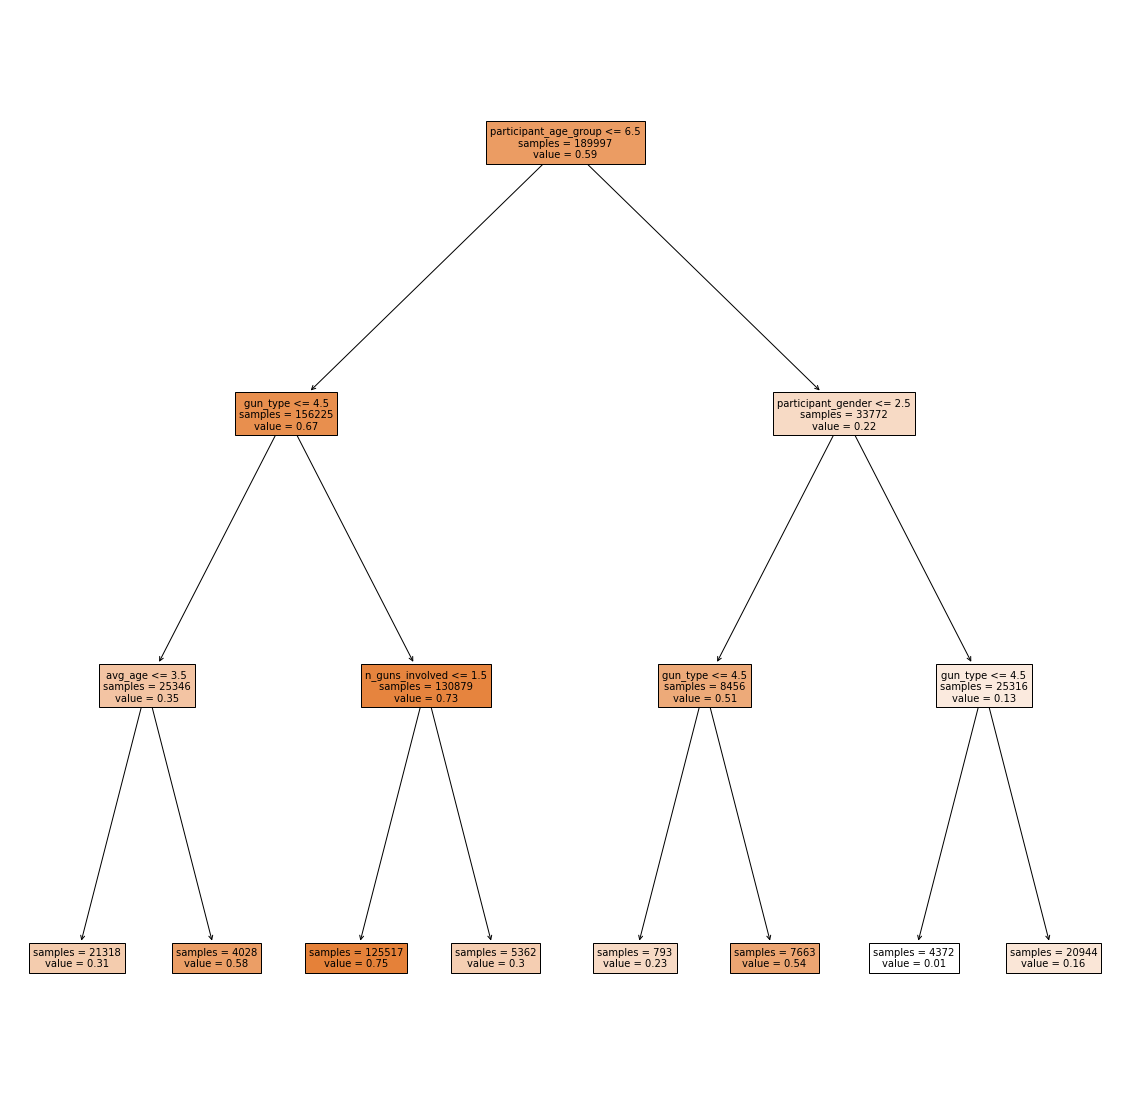

In [32]:
#se grafica el arbol
fig, ax = plt.subplots(figsize=(20, 20))

print(f"Profundidad del árbol: {modelo.get_depth()}")
print(f"Número de nodos terminales: {modelo.get_n_leaves()}")

plot = plot_tree(
            decision_tree = modelo,
            feature_names = variables_independientes.columns,
            class_names   = 'Numero de muertes',
            filled        = True,
            impurity      = False,
            fontsize      = 10,
            precision     = 2,
            ax            = ax
       )

In [35]:
texto_modelo = export_text(# se obtinen los textos del arbol
                    decision_tree = modelo,
                    feature_names = list(variables_independientes.columns)
               )
print(texto_modelo)

|--- participant_age_group <= 6.50
|   |--- gun_type <= 4.50
|   |   |--- avg_age <= 3.50
|   |   |   |--- value: [0.31]
|   |   |--- avg_age >  3.50
|   |   |   |--- value: [0.58]
|   |--- gun_type >  4.50
|   |   |--- n_guns_involved <= 1.50
|   |   |   |--- value: [0.75]
|   |   |--- n_guns_involved >  1.50
|   |   |   |--- value: [0.30]
|--- participant_age_group >  6.50
|   |--- participant_gender <= 2.50
|   |   |--- gun_type <= 4.50
|   |   |   |--- value: [0.23]
|   |   |--- gun_type >  4.50
|   |   |   |--- value: [0.54]
|   |--- participant_gender >  2.50
|   |   |--- gun_type <= 4.50
|   |   |   |--- value: [0.01]
|   |   |--- gun_type >  4.50
|   |   |   |--- value: [0.16]



In [36]:
importancia_predictores = pd.DataFrame( # se obtiene la importancion de cada predictor utilizado en el arbol
                            {'predictor': variables_independientes.columns,
                             'importancia': modelo.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
5,participant_age_group,0.504528
3,gun_type,0.293267
4,n_guns_involved,0.096501
6,participant_gender,0.083050
7,avg_age,0.022653
0,month,0.000000
1,day,0.000000
2,gun_stolen,0.000000
8,state2,0.000000


In [39]:
predicciones = modelo.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 0.42523074849391684


In [40]:
acc_decision_test = round(modelo.score(X_test, y_test) * 100, 2) #se obtiene la precision de los datos
print("precisión: ",acc_decision_test, "%")

precisión:  24.93 %


In [41]:
acc_decision_train = round(modelo.score(X_train, y_train) * 100, 2) #se obtiene la precision de los datos
print("precisión: ",acc_decision_train, "%")

precisión:  24.05 %


**Arbol profundidad 5**

In [42]:
modelo5 = DecisionTreeRegressor(
            max_depth         = 5,
            random_state = 123
          )

modelo5.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=123, splitter='best')

Profundidad del árbol: 5
Número de nodos terminales: 32


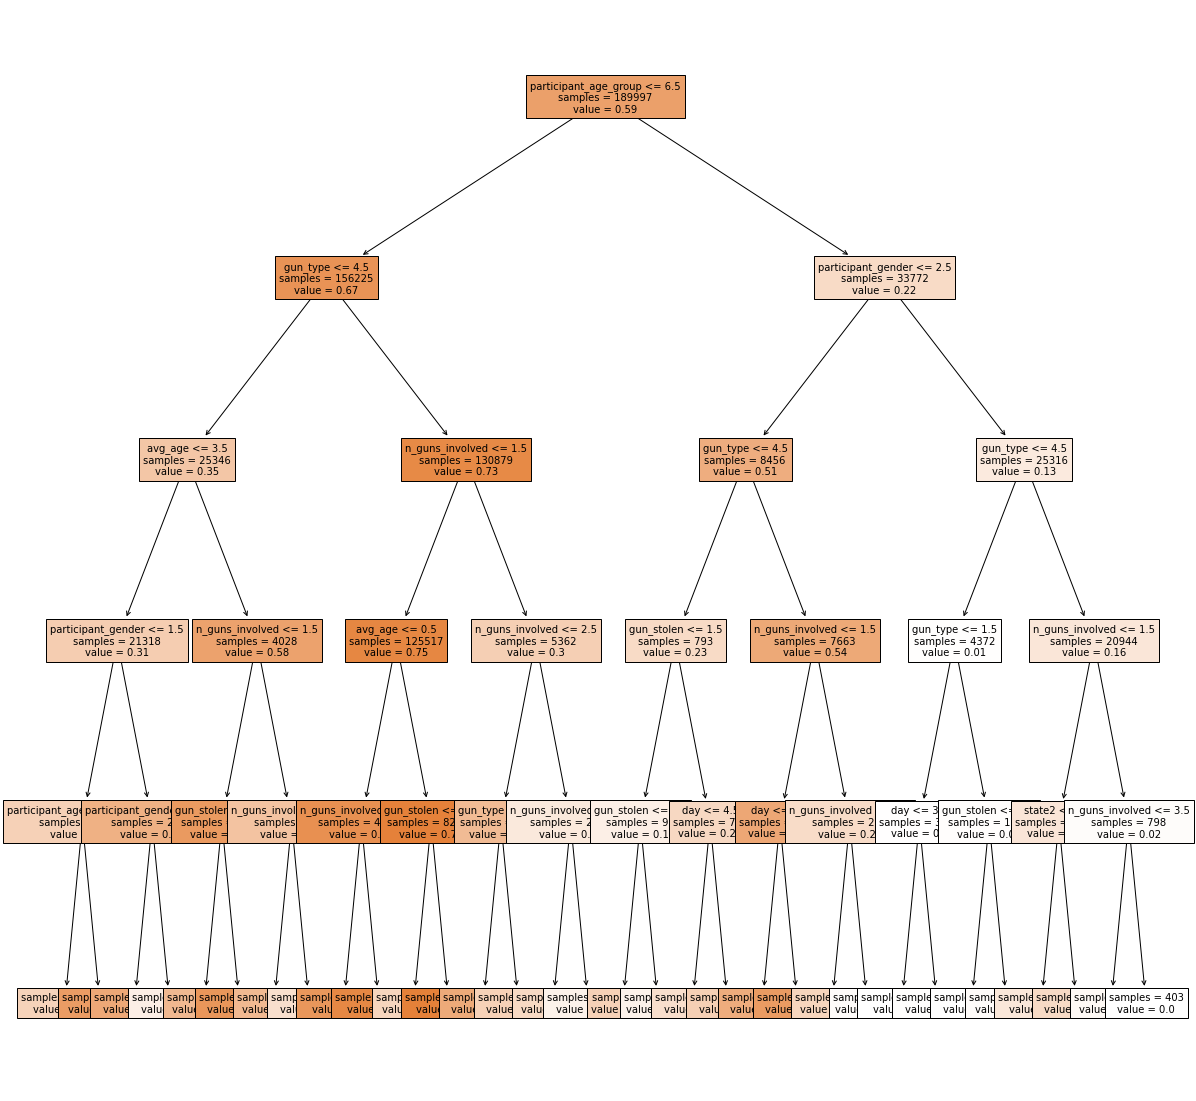

In [43]:
fig, ax = plt.subplots(figsize=(20, 20))

print(f"Profundidad del árbol: {modelo5.get_depth()}")
print(f"Número de nodos terminales: {modelo5.get_n_leaves()}")

plot = plot_tree(
            decision_tree = modelo5,
            feature_names = variables_independientes.columns,
            class_names   = 'Numero de muertos',
            filled        = True,
            impurity      = False,
            fontsize      = 10,
            precision     = 2,
            ax            = ax
       )

In [44]:
texto_modelo5 = export_text(
                    decision_tree = modelo5,
                    feature_names = list(variables_independientes.columns)
               )
print(texto_modelo5)

|--- participant_age_group <= 6.50
|   |--- gun_type <= 4.50
|   |   |--- avg_age <= 3.50
|   |   |   |--- participant_gender <= 1.50
|   |   |   |   |--- participant_age_group <= 3.00
|   |   |   |   |   |--- value: [0.28]
|   |   |   |   |--- participant_age_group >  3.00
|   |   |   |   |   |--- value: [0.62]
|   |   |   |--- participant_gender >  1.50
|   |   |   |   |--- participant_gender <= 2.50
|   |   |   |   |   |--- value: [0.54]
|   |   |   |   |--- participant_gender >  2.50
|   |   |   |   |   |--- value: [0.10]
|   |   |--- avg_age >  3.50
|   |   |   |--- n_guns_involved <= 1.50
|   |   |   |   |--- gun_stolen <= 1.50
|   |   |   |   |   |--- value: [0.44]
|   |   |   |   |--- gun_stolen >  1.50
|   |   |   |   |   |--- value: [0.65]
|   |   |   |--- n_guns_involved >  1.50
|   |   |   |   |--- n_guns_involved <= 2.50
|   |   |   |   |   |--- value: [0.44]
|   |   |   |   |--- n_guns_involved >  2.50
|   |   |   |   |   |--- value: [0.20]
|   |--- gun_type >  4.50
|   |

In [45]:
importancia_predictores = pd.DataFrame(
                            {'predictor': variables_independientes.columns,
                             'importancia': modelo5.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
5,participant_age_group,0.468166
3,gun_type,0.273081
4,n_guns_involved,0.113701
6,participant_gender,0.088771
7,avg_age,0.041282
2,gun_stolen,0.012431
1,day,0.001614
8,state2,0.000955
0,month,0.000000


In [46]:
predicciones = modelo5.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 0.42015525909322443


In [47]:
acc_decision_test = round(modelo5.score(X_test, y_test) * 100, 2) #se obtiene la precision de los datos
print("precisión: ",acc_decision_test, "%")

precisión:  26.71 %


In [48]:
acc_decision_train = round(modelo5.score(X_train, y_train) * 100, 2) #se obtiene la precision de los datos
print("precisión: ",acc_decision_train, "%")

precisión:  26.18 %


**Profundidad 3 con Adaboost**

In [49]:
#se utiliza adaboost para la mejora de la prediccion con un arbol de profundidad 4
regr_1 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=3), 
                          n_estimators=300, random_state=123)

regr_1.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                       criterion='mse',
                                                       max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                                                       random_state=None,
                                                       splitter='best'),
                  

In [50]:
importancia_predictores = pd.DataFrame(
                            {'predictor': variables_independientes.columns,
                             'importancia': regr_1.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
5,participant_age_group,0.392952
3,gun_type,0.281203
6,participant_gender,0.188919
4,n_guns_involved,0.072594
2,gun_stolen,0.037315
7,avg_age,0.026640
1,day,0.000377
0,month,0.000000
8,state2,0.000000


In [51]:
predicciones = regr_1.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 0.4322985182667326


In [52]:
acc_decision_test = round(regr_1.score(X_test, y_test) * 100, 2) #se obtiene la precision de los datos
print("precisión: ",acc_decision_test, "%")

precisión:  22.41 %


In [53]:
acc_decision_train = round(regr_1.score(X_train, y_train) * 100, 2) #se obtiene la precision de los datos
print("precisión: ",acc_decision_train, "%")

precisión:  21.88 %


**Profundidad 5 con Adaboost**

In [54]:
#se utiliza adaboost para la mejora de la prediccion con un arbol de profundidad 4
regr_3 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=5), 
                          n_estimators=300, random_state=123)

regr_3.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                       criterion='mse',
                                                       max_depth=5,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                                                       random_state=None,
                                                       splitter='best'),
                  

In [55]:
importancia_predictores = pd.DataFrame(
                            {'predictor': variables_independientes.columns,
                             'importancia': regr_3.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
5,participant_age_group,0.358214
3,gun_type,0.261213
6,participant_gender,0.156874
4,n_guns_involved,0.097223
7,avg_age,0.051845
2,gun_stolen,0.044504
1,day,0.020455
8,state2,0.008125
0,month,0.001547


In [56]:
predicciones = regr_3.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 0.4306276449634627


In [57]:
acc_decision_test = round(regr_3.score(X_test, y_test) * 100, 2) #se obtiene la precision de los datos
print("precisión: ",acc_decision_test, "%")

precisión:  23.01 %


In [58]:
acc_decision_train = round(regr_3.score(X_train, y_train) * 100, 2) #se obtiene la precision de los datos
print("precisión: ",acc_decision_train, "%")

precisión:  22.81 %
